<a href="https://colab.research.google.com/github/mckolu/integrateai/blob/main/Sentiment_Analysis_with_Transformers_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IMPORT & PREPROCESS REDDIT DATA**

In [38]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/mckolu/integrateai/main/reddit_data.csv")
# data.head(5)

In [39]:
cleaned_data = data.dropna(subset=['title_comments_text', 'title_comments_time_fixed'], how='any')
cleaned_data = cleaned_data.applymap(str)

import re
cleaned_data['title_comments_text'] = cleaned_data['title_comments_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

## **SENTIMENT ANALYSIS**

In [ ]:
!pip install transformers
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# from IPython.display import clear_output
# clear_output()

# data = ["Trying to lock up the barn after the horse has bolted... I saw an iguana chasing a full grown cat across Biscayne Blvd in North Miami last year. And the year before, I was walking across my apartment complex to check the mail & as I passed under a low-hanging tree limb, the iguana sunning itself decided to thwop me upside the head with its tail! Those scaly bastards are a menace!"]
# sentiment_pipeline(data)

In [41]:
data_list = cleaned_data['title_comments_text'].tolist()
sentiment_results = sentiment_pipeline(data_list)

In [42]:
sentiment = []
for each in sentiment_results:
  sentiment.append(list(each.values())[0])

# sentiment

In [43]:
cleaned_data.insert(8, 'sentiment', sentiment)

# cleaned_data['sentiment'] = sentiment
cleaned_data.head(5)

,title_subreddit,title_user,title_text,title_time,title_vote,title_comment_count,title_comments_user,title_comments_text,sentiment,title_comments_time,title_comments_time_fixed,title_comments_vote
0,r/news,PandaMuffin1,"Pythons, iguanas: Florida restricts some exoti...",Fri Feb 26 21:52:41 2021 UTC,98 points,32 comments,SixIsNotANumber,Trying to lock up the barn after the horse has...,NEGATIVE,Fri Feb 26 21:58:03 2021 UTC,2/26/21,40 points
1,r/news,PandaMuffin1,"Pythons, iguanas: Florida restricts some exoti...",Fri Feb 26 21:52:41 2021 UTC,98 points,32 comments,TheFrogWife,"Iguanas ar edible, let people catch and eat them",POSITIVE,Fri Feb 26 23:46:16 2021 UTC,2/26/21,11 points
2,r/news,PandaMuffin1,"Pythons, iguanas: Florida restricts some exoti...",Fri Feb 26 21:52:41 2021 UTC,98 points,32 comments,PandaMuffin1,Better late than never Florida. They are alrea...,NEGATIVE,Fri Feb 26 21:55:09 2021 UTC,2/26/21,10 points
3,r/news,PandaMuffin1,"Pythons, iguanas: Florida restricts some exoti...",Fri Feb 26 21:52:41 2021 UTC,98 points,32 comments,Burnblast277,It'd be great to list... what those species are,POSITIVE,Fri Feb 26 23:36:37 2021 UTC,2/26/21,5 points
4,r/news,PandaMuffin1,"Pythons, iguanas: Florida restricts some exoti...",Fri Feb 26 21:52:41 2021 UTC,98 points,32 comments,haroldthehampster,A bit late for that kind of measure. They’ve o...,NEGATIVE,Sat Feb 27 13:49:45 2021 UTC,2/27/21,3 points


Word Count Median: 11.0
count    684.000000
mean      18.343567
std       24.179849
min        1.000000
25%        5.000000
50%       11.000000
75%       21.000000
max      284.000000
Name: word_count, dtype: float64


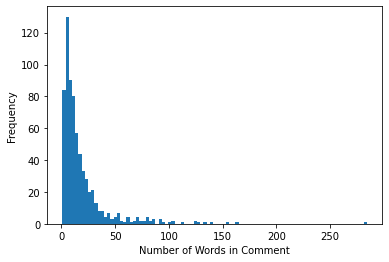

In [44]:
from matplotlib import pyplot as plt
df = cleaned_data

df['word_count'] = df['title_comments_text'].apply(lambda x: len(str(x).split(" ")))

print("Word Count Median: " + str(df['word_count'].median()))
print(df['word_count'].describe())
x = df['word_count']
n_bins = 95
plt.hist(x, bins=n_bins)
plt.xlabel('Number of Words in Comment')
plt.ylabel('Frequency')
plt.show()


In [45]:
df['sentiment'].value_counts()

NEGATIVE    436
POSITIVE    248
Name: sentiment, dtype: int64

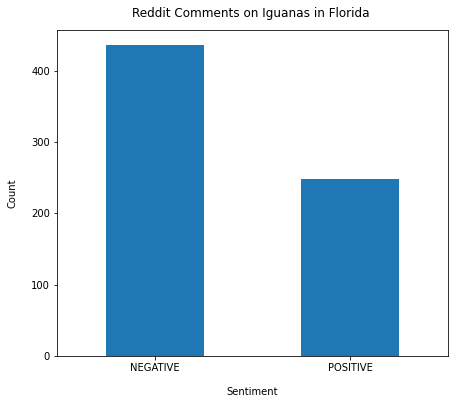

In [46]:
# df['sentiment'].value_counts().plot(kind='bar')

df['sentiment'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Sentiment", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Reddit Comments on Iguanas in Florida ", y=1.02);


## **K-MEANS CLUSTERING**

In [47]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#create a list of stop words
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words("english"))
#show how many words are in the list of stop words

stop_words.add('like')
stop_words.add('florida')
print(len(stop_words))

181


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [48]:
# construct a new list to store the cleaned text
clean_desc = []
for each in data_list:
  desc = each.lower()
  desc = re.sub('[^a-zA-Z]', ' ', desc)
  desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
  desc = re.sub("(\\d|\\W)+"," ",desc)
  split_text = desc.split()

  lem = WordNetLemmatizer()
  split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words and len(word) >2] 
  split_text = " ".join(split_text)
  clean_desc.append(split_text)



In [49]:
#TF-IDF vectorizer
tfv = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,2))
#transform
vec_text = tfv.fit_transform(clean_desc)
#returns a list of words.
words = tfv.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
#setup kmeans clustering
kmeans = KMeans(n_clusters = 4, tol = 0.00001, max_iter = 200)
#fit the data 
kmeans.fit(vec_text)
#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : invasive, specie, invasive specie, eat, iguana, taste, chicken, people, know, iguana invasive
1 : iguana, want, frozen, frozen iguana, eating, stick, large, toilet, man, year
2 : lizard, tail, live, iguana, south, everywhere, big lizard, know, look, curly
3 : get, man, floridaman, news, way, one, life, dead, cold, look


## **POST and SENTIMENT OVER TIME**

In [84]:
df['title_comments_time_fixed'] = pd.to_datetime(data['title_comments_time_fixed'])
# print(type(data.title_comments_time_fixed[0]))

df.sort_values(by='title_comments_time_fixed', inplace=True, ascending=True)


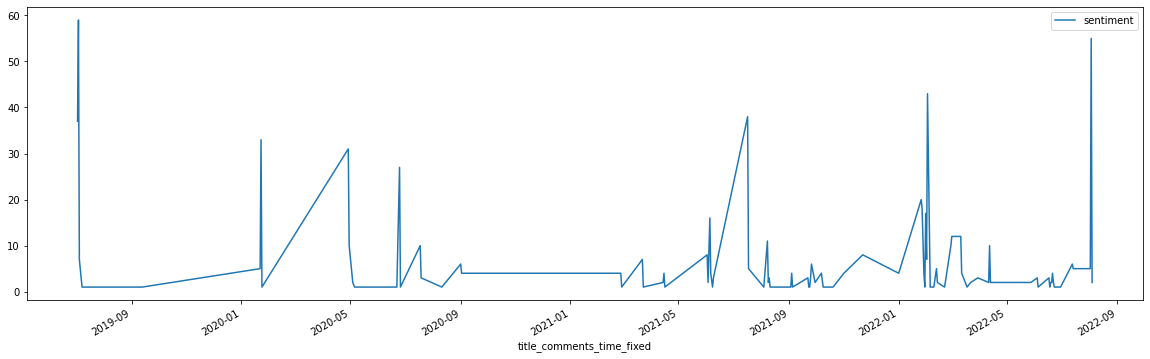

In [89]:
# NEEDS TO BE FIXED

df.groupby(['title_comments_time_fixed'])['sentiment'].count().plot(legend=True, figsize=(20, 6))

## **WORD2VEC and K-MEANS**